<a href="https://colab.research.google.com/github/jihyoung-lee/stock_news_classifier/blob/main/stock_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade transformers==4.51.3
!pip install --upgrade evaluate
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [4]:
pip install tf-keras

In [6]:
import transformers
from transformers import TrainingArguments

print(transformers.__version__)
print(TrainingArguments.__init__.__doc__)

4.51.3
None


In [21]:
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
import pandas as pd
import evaluate
import matplotlib.pyplot as plt

# Load model & tokenizer
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
)

# Freeze embedding & lower encoder layers
for name, param in model.bert.named_parameters():
    if any(layer in name for layer in ["embeddings", "encoder.layer.0", "encoder.layer.1"]):
        param.requires_grad = False

# Load dataset
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
})

# Preprocessing
def preprocess_function(examples):
    inputs = tokenizer(examples["title"], padding=True, truncation=True)
    inputs["labels"] = examples["label"]
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metric
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Training args
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

<ipython-input-21-13483c567fe3>:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.636700,0.571709,0.736111,0.734423,0.724868,0.727218
2,0.519700,0.483621,0.763889,0.768501,0.749559,0.753176
3,0.402900,0.445518,0.791667,0.793258,0.781305,0.784646


TrainOutput(global_step=216, training_loss=0.5032893375114158, metrics={'train_runtime': 94.2826, 'train_samples_per_second': 18.201, 'train_steps_per_second': 2.291, 'total_flos': 38800658445120.0, 'train_loss': 0.5032893375114158, 'epoch': 3.0})

In [24]:
print(trainer.evaluate())

{'eval_loss': 0.4455178678035736, 'eval_accuracy': 0.7916666666666666, 'eval_precision': 0.7932584269662921, 'eval_recall': 0.781305114638448, 'eval_f1': 0.7846460618145563, 'eval_runtime': 0.4896, 'eval_samples_per_second': 294.106, 'eval_steps_per_second': 36.763, 'epoch': 3.0}


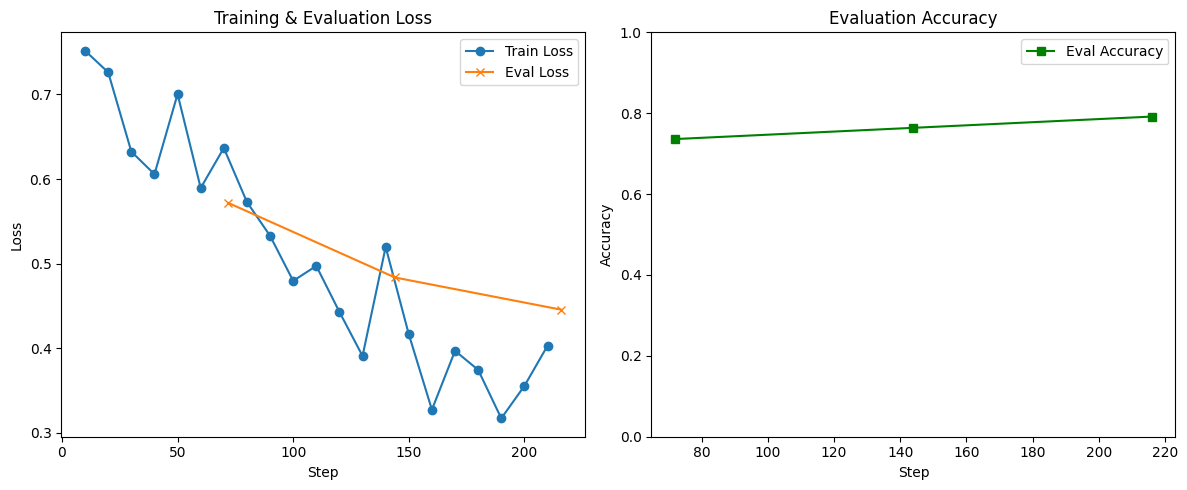

In [22]:
import matplotlib.pyplot as plt
import json

# trainer_state.json 열기
with open('./results/checkpoint-360/trainer_state.json', 'r', encoding='utf-8') as f:
    log_data = json.load(f)

log_history = log_data['log_history']

import matplotlib.pyplot as plt

train_steps, train_loss = [], []
eval_steps, eval_loss, eval_accuracy = [], [], []

for entry in trainer.state.log_history:
    if 'loss' in entry and 'eval_loss' not in entry:  # 순수한 train loss
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry.get('eval_accuracy'))  # 없을 수도 있어서 get 사용

# --- 그래프 그리기 ---
plt.figure(figsize=(12, 5))

# 1) Train Loss + Eval Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss', marker='o')
plt.plot(eval_steps, eval_loss, label='Eval Loss', marker='x')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Evaluation Loss')
plt.legend()

# 2) Eval Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, color='green', label='Eval Accuracy', marker='s')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()




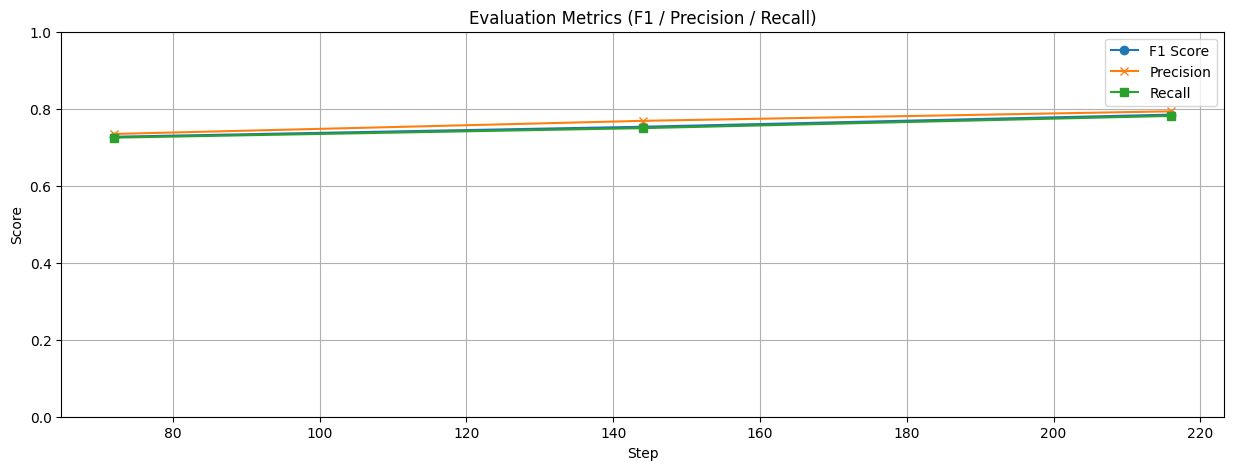

In [23]:
# 평가 지표들 기록
eval_f1, eval_precision, eval_recall = [], [], []

for entry in trainer.state.log_history:
    if 'eval_f1' in entry:
        eval_f1.append((entry['step'], entry['eval_f1']))
    if 'eval_precision' in entry:
        eval_precision.append((entry['step'], entry['eval_precision']))
    if 'eval_recall' in entry:
        eval_recall.append((entry['step'], entry['eval_recall']))

# 시각화
plt.figure(figsize=(15, 5))

# F1
if eval_f1:
    x, y = zip(*eval_f1)
    plt.plot(x, y, marker='o', label='F1 Score')

# Precision
if eval_precision:
    x, y = zip(*eval_precision)
    plt.plot(x, y, marker='x', label='Precision')

# Recall
if eval_recall:
    x, y = zip(*eval_recall)
    plt.plot(x, y, marker='s', label='Recall')

plt.xlabel("Step")
plt.ylabel("Score")
plt.title("Evaluation Metrics (F1 / Precision / Recall)")
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델 저장
trainer.save_model("./my_model")
tokenizer.save_pretrained("./my_model")

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json')

In [ ]:
# 모델 압축 해제
import os
import zipfile

zip_path = "/content/mymodel.zip"
model_path = "/content/mymodel"
# 폴더 없으면 생성
os.makedirs(model_path, exist_ok=True)
# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(model_path)


In [ ]:
# 모델 불러오기
model_path="/content/my_model"
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

In [ ]:
# 예측하기
model_path = "./my_model"
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

text = "오늘의 급등주 ㅇㅇ회사 주가 상승 흐름.."

# 입력 전처리
input = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

# 예측
output = model(**input)
logits = output.logits

#확률로 변환
import torch
probs = torch.softmax(logits, dim=1)

PRBBL_PSTV = probs[0][1].item()
PRBBL_NGTV = probs[0][0].item()
# 결과 출력
print(f"호재 확률: {PRBBL_PSTV:.2f}")
print(f"악재 확률: {PRBBL_NGTV:.2f}")

호재 확률: 1.00
악재 확률: 0.00
